In [142]:
from copy import deepcopy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import pm4py
import scipy
import stormpy
from copy import deepcopy
import numpy as np

In [144]:
from simulation.markov_models import log_parser
from simulation.markov_chain import apply as mc_apply
from simulation.markov_chain_vis import view_markov_chain, view_resource_markov_chain, view_non_resource_markov_chain
import simulation.util as sim_util

In [145]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, sem, t
from datetime import datetime, timedelta

# Simulation parameters
np.random.seed(42)
num_traces = 1000
event_labels = ["Start", "Middle", "End"]
rate_start_middle = 0.25  # events per hour
rate_middle_end = 0.25    # events per hour
rate_start_end = 0.25 # events per hour
true_rates = {
    ("Start", "Middle"): rate_start_middle,
    ("Middle", "End"): rate_middle_end,
    ("Start", "End"): rate_middle_end
}

# Time unit configuration: choose "seconds" or "hours"
time_unit = "hours"  # or "seconds"
time_factor = 1 if time_unit == "seconds" else 1 / 3600  # seconds to chosen unit

# Generate synthetic event log
rows = []
for case_id in range(1, num_traces + 1):
    current_time = datetime.now()
    case_id_str = str(case_id)

    rows.append({
        "case:concept:name": case_id_str,
        "concept:name": "Start",
        "org:role": "R1",
        "org:resource": "R1",
        "time:timestamp": current_time
    })
    go_middle = bool(random.getrandbits(1))
    if go_middle:
        # current_time += timedelta(hours=np.random.normal(loc=8.0, scale=1.0))
        current_time += timedelta(seconds=np.random.exponential(3600 / rate_start_middle))  # convert hours to seconds

        rows.append({
            "case:concept:name": case_id_str,
            "concept:name": "Middle",
            "org:role": "R1",
            "org:resource": "R1",
            "time:timestamp": current_time
        })

    # if not go_middle:
    current_time += timedelta(seconds=np.random.exponential(3600 / rate_middle_end))
    # current_time += timedelta(hours=4)
    rows.append({
        "case:concept:name": case_id_str,
        "concept:name": "End",
        "org:role": "R1",
        "org:resource": "R1",
        "time:timestamp": current_time
    })

# Create DataFrame
df = pd.DataFrame(rows)
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])
df = df.sort_values(by=["case:concept:name", "time:timestamp"]).reset_index(drop=True)

# Extract time deltas in desired unit
time_diffs = {}
for case_id, group in df.groupby("case:concept:name"):
    events = group["concept:name"].tolist()
    times = group["time:timestamp"].tolist()
    for i in range(len(events) - 1):
        pair = (events[i], events[i + 1])
        delta_time = (times[i + 1] - times[i]).total_seconds() * time_factor
        time_diffs.setdefault(pair, []).append(delta_time)


In [146]:
time_diffs.keys()

dict_keys([('Start', 'End'), ('Start', 'Middle'), ('Middle', 'End')])

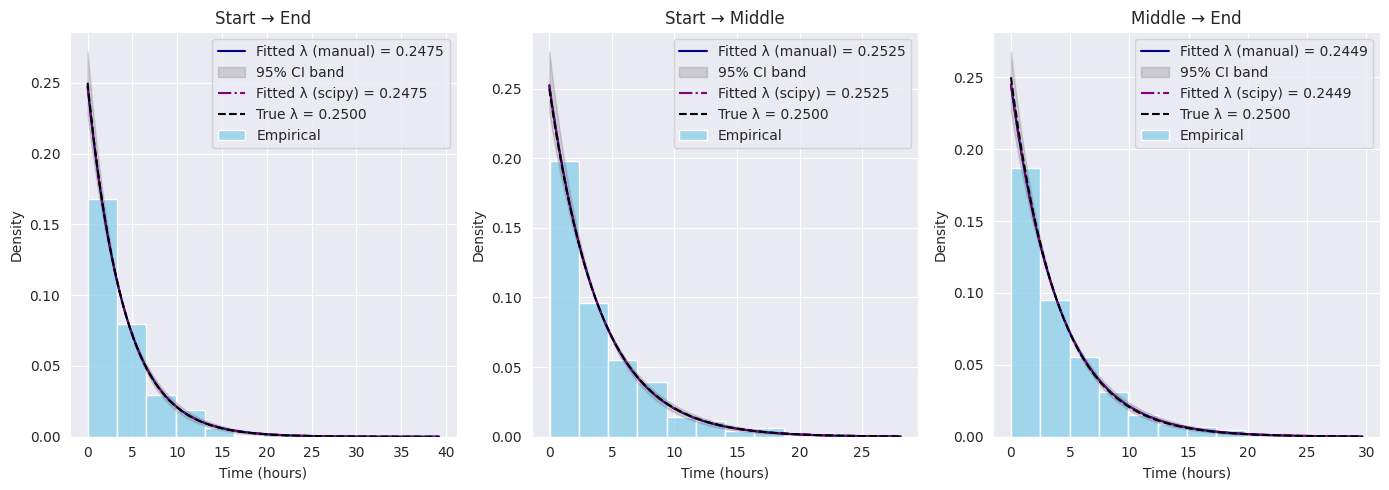

In [147]:
# Plot histogram and exponential fits
fig, axes = plt.subplots(1, len(time_diffs), figsize=(14, 5))

for ax, (pair, deltas) in zip(axes, time_diffs.items()):
    deltas = np.array(deltas)
    mean_time = deltas.mean()
    n = len(deltas)

    # Manual exponential fit
    rate_manual = 1 / mean_time
    ci_half_width = t.ppf(0.975, df=n-1) * sem(deltas)
    lower_rate = 1 / (mean_time + ci_half_width)
    upper_rate = 1 / (mean_time - ci_half_width)

    # Scipy fit with loc fixed to 0
    loc, scale = expon.fit(deltas, floc=0)
    rate_scipy = 1 / scale

    # True rate
    rate_true = true_rates[pair]
    if time_unit == "seconds":
        rate_true /= 3600  # convert per hour to per second

    # Plot histogram
    sns.histplot(deltas, bins=10, stat="density", ax=ax, color="skyblue", label="Empirical")

    # X values for plotting
    x_vals = np.linspace(0, max(deltas) * 1.2, 200)

    # PDF curves
    ax.plot(x_vals, expon.pdf(x_vals, scale=1 / rate_manual), color="darkblue",
            label=f"Fitted λ (manual) = {rate_manual:.4f}")
    ax.fill_between(x_vals,
                    expon.pdf(x_vals, scale=1 / lower_rate),
                    expon.pdf(x_vals, scale=1 / upper_rate),
                    color="gray", alpha=0.3, label="95% CI band")
    ax.plot(x_vals, expon.pdf(x_vals, scale=1 / rate_scipy), linestyle="-.", color="purple",
            label=f"Fitted λ (scipy) = {rate_scipy:.4f}")
    ax.plot(x_vals, expon.pdf(x_vals, scale=1 / rate_true), linestyle="dashed", color="black",
            label=f"True λ = {rate_true:.4f}")

    # Labels and titles
    ax.set_title(f"{pair[0]} → {pair[1]}")
    ax.set_xlabel(f"Time ({time_unit})")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

In [148]:
import pm4py

pm4py.write_xes(df, "test.xes")

exporting log, completed traces :: 100%|██████████| 1000/1000 [00:00<00:00, 22133.76it/s]


In [149]:
df

,case:concept:name,concept:name,org:role,org:resource,time:timestamp
0,1,Start,R1,R1,2025-05-20 11:03:27.062449
1,1,End,R1,R1,2025-05-20 12:56:04.522945
2,10,Start,R1,R1,2025-05-20 11:03:27.062514
3,10,Middle,R1,R1,2025-05-20 11:51:36.839952
4,10,End,R1,R1,2025-05-20 12:40:14.444441
...,...,...,...,...,...
2514,998,Middle,R1,R1,2025-05-20 11:07:52.038190
2515,998,End,R1,R1,2025-05-20 12:00:09.508904
2516,999,Start,R1,R1,2025-05-20 11:03:27.066035
2517,999,Middle,R1,R1,2025-05-20 11:05:16.385342


In [150]:
final_states = ['End']

In [151]:
subset_el = pm4py.convert_to_event_log(df)
subset_el = log_parser.add_start_end(subset_el)
dfg, start_activities, end_activities = pm4py.discover_dfg(subset_el)
dfg["end", "start"] = 1

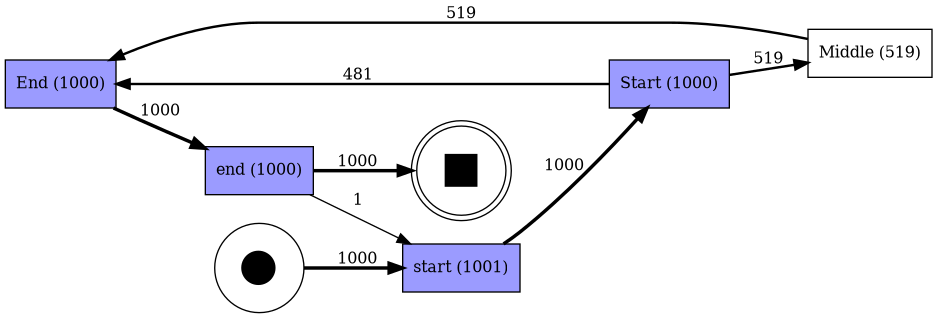

In [152]:
pm4py.view_dfg(dfg, start_activities, end_activities)

In [153]:
subset_el = pm4py.convert_to_dataframe(subset_el)

In [154]:
from simulation.timings import Timings

In [155]:
timings = Timings()
resource_input_array = timings.create_resource_input_array_from_log(subset_el)
res_timings = timings.get_timings_per_resource(subset_el, resource_input_array)
times_dictionary = res_timings

In [156]:
def extract_times_event_log(log_input):
    if type(log_input) == pd.DataFrame:
        log = pm4py.convert_to_event_log(deepcopy(log_input))
    else:
        log = deepcopy(log_input)
    times = []
    for trace in log:
        start = trace[0]['time:timestamp']
        end = trace[len(trace)-1] ['time:timestamp']
        time = end - start
        times.append(time.total_seconds())
    return times

def extract_times_with_future(log_input):
    times_dictionary = {}
    if type(log_input) == pd.DataFrame:
        log = pm4py.convert_to_event_log(deepcopy(log_input))
    else:
        log = deepcopy(log_input)
    for trace in log:
        first = True
        for next_event in trace:
            if not first and next_event['concept:name'] != 'end' and event['concept:name'] != 'start':
                time = next_event['time:timestamp'] - event['time:timestamp']
                if not (event['concept:name'], next_event['concept:name']) in times_dictionary.keys():
                    times_dictionary[(event['concept:name'], next_event['concept:name'])] = [time.total_seconds()]
                else:
                    times_dictionary[(event['concept:name'], next_event['concept:name'])].append(time.total_seconds())
            event = next_event
            first = False
    return times_dictionary

In [157]:
extract_times_with_future(subset_el)

{('Start', 'End'): [6757.460496,
  3990.885315,
  16058.232148,
  20647.981818,
  6602.728309,
  14407.253967,
  5570.068229,
  5223.653704,
  3698.267718,
  14920.190518,
  7041.005294,
  39748.950976,
  30216.005383,
  1407.256423,
  32761.774443,
  14793.273987,
  32950.519203,
  1540.755381,
  15683.938377,
  11458.048984,
  3899.86213,
  2163.377214,
  1416.341685,
  9767.42544,
  14932.350523,
  5488.505733,
  2674.348075,
  11717.812686,
  39618.62598,
  17147.888608,
  12155.217645,
  10519.13268,
  3207.396415,
  10311.742612,
  15115.954678,
  17431.929339,
  10397.219832,
  1421.222964,
  446.040894,
  6430.824349,
  21162.930342,
  12924.067987,
  10913.888745,
  11201.910375,
  14609.339254,
  10458.592117,
  5616.283883,
  8322.96141,
  1176.554428,
  43345.748605,
  369.757577,
  4147.286243,
  44612.690379,
  13622.838797,
  2692.242028,
  7834.145264,
  20421.818608,
  208.772348,
  1776.677648,
  678.159028,
  598.772908,
  27852.523684,
  1482.579626,
  2738.803864,


In [158]:
times_dictionary

{('Start',
  'End',
  'R1'): array([6.75746050e+03, 3.99088531e+03, 1.60582321e+04, 2.06479818e+04,
        6.60272831e+03, 1.44072540e+04, 5.57006823e+03, 5.22365370e+03,
        3.69826772e+03, 1.49201905e+04, 7.04100529e+03, 3.97489510e+04,
        3.02160054e+04, 1.40725642e+03, 3.27617744e+04, 1.47932740e+04,
        3.29505192e+04, 1.54075538e+03, 1.56839384e+04, 1.14580490e+04,
        3.89986213e+03, 2.16337721e+03, 1.41634169e+03, 9.76742544e+03,
        1.49323505e+04, 5.48850573e+03, 2.67434807e+03, 1.17178127e+04,
        3.96186260e+04, 1.71478886e+04, 1.21552176e+04, 1.05191327e+04,
        3.20739642e+03, 1.03117426e+04, 1.51159547e+04, 1.74319293e+04,
        1.03972198e+04, 1.42122296e+03, 4.46040894e+02, 6.43082435e+03,
        2.11629303e+04, 1.29240680e+04, 1.09138887e+04, 1.12019104e+04,
        1.46093393e+04, 1.04585921e+04, 5.61628388e+03, 8.32296141e+03,
        1.17655443e+03, 4.33457486e+04, 3.69757577e+02, 4.14728624e+03,
        4.46126904e+04, 1.36228388e+

In [159]:
data_transition_role_frequency = sim_util.get_transition_resource_dict(subset_el)

In [160]:
data_mean_transition_role_time = {}
tuples_to_discard = set()
for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0
        for k3,v3 in v2.items():
            all_freq += v3
            if (k,k2,k3) in times_dictionary:
                times = times_dictionary[(k,k2,k3)]
                times = np.array(times)
                times = times/3600
                times = times[times != 0]
                if len(times) > 1: # only take times that have more than 1 value
                    expon_loc, expon_scale = scipy.stats.expon.fit(times)

                    # f = Fitter(times, distributions=['expon'])
                    # f.fit()
                    # best = f.get_best()['expon']
                    # expon_loc_fitter, expon_scale_fitter = best['loc'], best['scale']

                    if expon_scale>0: # do not take times that cannot be fit into an exponential
                        rate = 1/expon_scale
                        if k not in data_mean_transition_role_time:
                            data_mean_transition_role_time[k] = {}
                        if k2 not in data_mean_transition_role_time[k]:
                            data_mean_transition_role_time[k][k2] = {}
                        if k3 not in data_mean_transition_role_time[k][k2]:
                            data_mean_transition_role_time[k][k2][k3] = {
                                # 'loc': expon_loc_fitter,
                                # 'scale': expon_scale_fitter,
                                'loc': expon_loc,
                                'scale': expon_scale,
                                'lambda': rate
                            }
                    else:
                        print(f"[No exponential!] {k},{k2},{k3}")
                        tuples_to_discard.add((k,k2,k3))
                        print(times)
                else:
                    print(f"[No times!] {k},{k2},{k3}")
                    tuples_to_discard.add((k,k2,k3))
                    print(times)

In [161]:
for (e_from,e_to,role) in tuples_to_discard:
    if e_from in data_transition_role_frequency:
        if e_to in data_transition_role_frequency[e_from]:
            if role in data_transition_role_frequency[e_from][e_to]:
                data_transition_role_frequency[e_from][e_to].pop(role)

In [162]:
for e_from in data_transition_role_frequency.keys():
    for e_to in data_transition_role_frequency.keys():
        if (e_from == 'start' and e_to == 'start') or (e_from == 'end' and e_to == 'end'):
            data_transition_role_frequency[e_from].pop(e_to)

In [163]:
def remove_empty_keys(d):
    """Recursively remove empty keys from a three-level nested dictionary."""
    if not isinstance(d, dict):
        return d  # Return non-dict values as they are

    cleaned_dict = {}
    for key, value in d.items():
        if isinstance(value, dict):
            cleaned_value = remove_empty_keys(value)  # Recursively clean sub-dictionaries
            if cleaned_value:  # Add only if not empty
                cleaned_dict[key] = cleaned_value
        elif value not in (None, "", [], {}, ()):  # Ignore empty values
            cleaned_dict[key] = value

    return cleaned_dict

data_transition_role_frequency = remove_empty_keys(data_transition_role_frequency)

In [164]:
role_resources = sim_util.get_detailed_weighted_role(subset_el)

In [165]:
role_trials = {k:int(v) for k,v in role_resources.items()}

In [166]:
res = {}
out_frequency = {}
data_transition_role_prob = {}

for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    out_freq = 0
    if k not in data_transition_role_prob:
        data_transition_role_prob[k] = {}

    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0

        if k2 not in data_transition_role_prob[k]:
            data_transition_role_prob[k][k2] = {}

        if k not in res:
            res[k] = {}
        if k2 not in res[k]:
            for k3,v3 in v2.items():
                if k3 not in data_transition_role_prob[k][k2]:
                    data_transition_role_prob[k][k2][k3] = v3
                all_freq += v3
            res[k][k2] = all_freq
            out_freq += all_freq
        out_frequency[k] = out_freq

for k,v in res.items():
    for k2,v2 in v.items():
        res[k][k2] = res[k][k2]/out_frequency[k]

for k,v in data_transition_role_prob.items():
    for k2,v2 in v.items():
        for k3,v3 in v2.items():
            data_transition_role_prob[k][k2][k3] = v3/out_frequency[k]

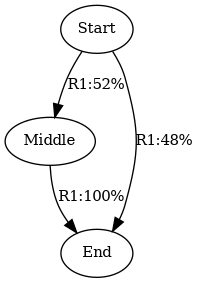

In [167]:
view_resource_markov_chain(data_transition_role_prob)

In [168]:
semi_markov_json = mc_apply(subset_el)

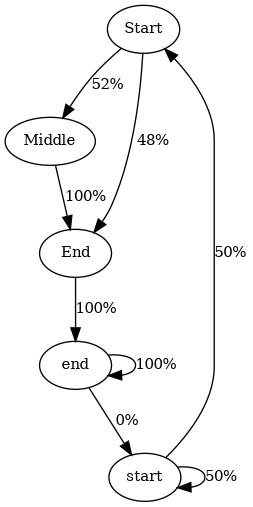

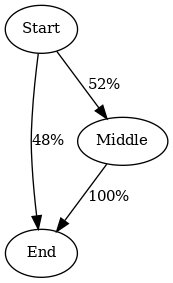

In [169]:
view_markov_chain(semi_markov_json)
view_non_resource_markov_chain(res)

In [170]:
states = set(subset_el['concept:name'].unique()).difference(set(['start','end']))
n = len(states)
i = 0
correspondence = {s:i for s,i in zip(states,range(len(states)))}
#TODO: make sure none of the final states have state = 0 in the prism program
non_final_states = list(states.difference(set(final_states)))
for s in final_states:
    if correspondence[s] == 0:
        correspondence[s] = correspondence[non_final_states[0]]
        correspondence[non_final_states[0]] = 0
correspondence

{'Middle': 0, 'End': 1, 'Start': 2}

In [171]:
from simulation.ctmc import create_prism_program_from_log

probabilities = create_prism_program_from_log(
                            correspondence,
                            final_states,
                            data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            role_trials,
                            'ctmc.sm')
# print(probabilities)

In [272]:
prism_program = stormpy.parse_prism_program('ctmc.sm',prism_compat=True,simplify=True)
model = stormpy.build_model(prism_program)
# print("Number of states: {}".format(model.nr_states))
# print("Number of transitions: {}".format(model.nr_transitions))
# print("Labels: {}".format(model.labeling.get_labels()))
labels = ""
for fs in final_states:
    labels += f'"q_terminal_{fs}" |'
labels = labels[:-2]

# formula_str = f'R=? [F {labels}]'
formula_str = f'Tmin=? [F {labels}]'
# formula_str = f'Rmin=? [C]'

properties = stormpy.parse_properties(formula_str, prism_program)
result = stormpy.model_checking(model, properties[0])
initial_state = model.initial_states[0]
result = result.at(initial_state)
print(f"Hours: {result}")
if result<np.inf:
    print(f"Duration: {timedelta(seconds=result)}")

Hours: 6.0
Duration: 0:00:06


# Simple choice program

In [173]:
# prism_program = stormpy.parse_prism_program('ctmc_simple_choice.sm',prism_compat=True,simplify=True)
prism_program = stormpy.parse_prism_program('ctmc_basic.sm',prism_compat=True,simplify=True)
model = stormpy.build_model(prism_program)
# print("Number of states: {}".format(model.nr_states))
# print("Number of transitions: {}".format(model.nr_transitions))
# print("Labels: {}".format(model.labeling.get_labels()))
labels = ""
for fs in final_states:
    labels += f'"q_terminal_{fs}" |'
labels = labels[:-2]

formula_str = f'R=? [F {labels}]'
properties = stormpy.parse_properties(formula_str, prism_program)
result = stormpy.model_checking(model, properties[0])
initial_state = model.initial_states[0]
result = result.at(initial_state)
print(f"Hours: {result}")
if result<np.inf:
    print(f"Duration: {timedelta(seconds=result)}")

Hours: 9.800000000000002
Duration: 0:00:09.800000
 WARN (Program.cpp:238): The input model is a CTMC, but uses probabilistic commands like they are used in PRISM. Consider rewriting the commands to use Markovian commands instead.


In [174]:
data_mean_transition_role_time

{'Start': {'End': {'R1': {'loc': 0.018571136388888892,
    'scale': 4.021621707286324,
    'lambda': 0.24865590868186643}},
  'Middle': {'R1': {'loc': 0.020297748333333334,
    'scale': 3.9399998390237636,
    'lambda': 0.25380711696876}}},
 'Middle': {'End': {'R1': {'loc': 0.023101221944444444,
    'scale': 4.059784455955363,
    'lambda': 0.2463184956859185}}}}

In [175]:
pm4py.get_cycle_time(subset_el)

0.0

In [176]:
pm4py.get_all_case_durations(subset_el)

[66.856091,
 71.312011,
 176.096799,
 208.772348,
 263.176998,
 355.729158,
 369.757577,
 374.062377,
 438.220525,
 446.040894,
 462.178753,
 491.148574,
 536.174523,
 541.21648,
 579.241457,
 598.772908,
 600.871863,
 611.448955,
 619.268845,
 635.31358,
 678.159028,
 680.632848,
 760.252005,
 761.055658,
 766.290981,
 846.447937,
 907.528717,
 955.627931,
 1011.566164,
 1079.098154,
 1094.588471,
 1124.791283,
 1153.501611,
 1165.280896,
 1176.554428,
 1204.354261,
 1244.56717,
 1287.174811,
 1309.422161,
 1334.238609,
 1407.256423,
 1416.341685,
 1421.222964,
 1482.579626,
 1529.644831,
 1540.755381,
 1590.462969,
 1623.152373,
 1629.317049,
 1664.705308,
 1685.760042,
 1688.311945,
 1693.366553,
 1730.573346,
 1756.559119,
 1776.677648,
 1800.377741,
 1804.047031,
 1810.801726,
 1836.908687,
 1838.597638,
 1844.221862,
 1851.209474,
 1917.30182,
 1973.065307,
 2014.779012,
 2048.776198,
 2163.377214,
 2166.011341,
 2173.744773,
 2222.030225,
 2279.013125,
 2290.779062,
 2372.542582

In [177]:
mean, median, margin_of_error = sim_util.get_pm4py_reference_times(subset_el)
print(timedelta(seconds=median))
print(timedelta(seconds=mean))
print(timedelta(seconds=margin_of_error))

4:40:20.072556
6:07:03.881541
0:20:10.195258


In [178]:
middle_mean = np.mean(times_dictionary[('Start','Middle','R1')]) + np.mean(times_dictionary[('Middle','End','R1')])
start_end_mean = np.mean(times_dictionary[('Start','End','R1')])
mean_all = np.mean([middle_mean, start_end_mean])
print(timedelta(seconds=mean_all))

6:02:30.076996
